<a href="https://www.kaggle.com/code/elza10/gans-for-mnist-generation?scriptVersionId=199932690" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing the required library


In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot  as plt

#the use of less precision

In [13]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Uploading the MNIST data set from the tensorflow library.

In [19]:
(ds_train, ds_test) = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)

In [15]:
(image, label) = next(iter(ds_train))
print(image.shape)  # Output: (28, 28, 1) -> Single-channel grayscale image
print(label)

(28, 28, 1)

tf.Tensor(4, shape=(), dtype=int64)


#Pre-processing the data

In [20]:
def normalize(image, label):
  #normalise the dataset
  image = tf.cast(image, tf.float32) / 255.0
  return image, label
ds_train = ds_train.map(normalize)
#shuffle the dataset to be sure that our model doesnt be biased by the information of the order.
ds_train = ds_train.shuffle(60000)
#define batch that the model will train on in each epachs
ds_train = ds_train.batch(batch_size=16)
#the prefetch function is used to prepare the data when the model is training, so when the model finish training the current batch will not wait for the next one to be download.
ds_train = ds_train.prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
(image, label) = next(iter(ds_train))
print(image.shape)  # Output: (28, 28, 1) -> Single-channel grayscale image
# print(image)

(16, 28, 28, 1)


In [6]:
type(image)

tensorflow.python.framework.ops.EagerTensor

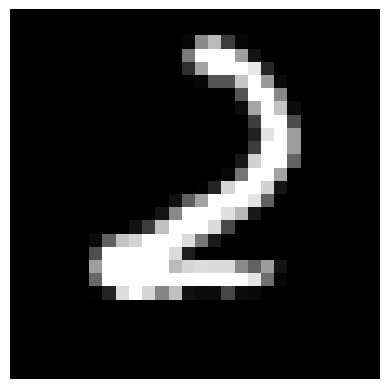

In [22]:
image_numpy = image[0].numpy()  # If the tensor is in Eager mode, convert to numpy

# Plot the image
plt.imshow(image_numpy, cmap='gray')  # For grayscale images like MNIST, use 'gray'
plt.axis('off')  # Hide axis
plt.show()

# GANs structure

**Implementing the Generator class**

In [8]:
import tensorflow as tf

class Generator:
    def __init__(self, nb_classes=10, noise_dim=100):
        self.nb_classes = nb_classes
        self.noise_dim = noise_dim

    def build(self):
        self.rand_vect = tf.keras.layers.Input(shape=(self.noise_dim,))
        self.label_input = tf.keras.layers.Input(shape=(self.nb_classes,))

        # Concatenate the random vector and label input
        self.concat_vect = tf.keras.layers.Concatenate()([self.rand_vect, self.label_input])

        # Dense layer with 7 * 7 * 128 units
        self.dense1 = tf.keras.layers.Dense(7 * 7 * 128)(self.concat_vect)
        self.leakyReLULayer = tf.keras.layers.LeakyReLU()(self.dense1)
        self.normalizing_leaky = tf.keras.layers.BatchNormalization()(self.leakyReLULayer)
        self.reshapeLayer = tf.keras.layers.Reshape((7, 7, 128))(self.normalizing_leaky)

        # Transposed convolutions
        self.transposed_conv1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same', activation='relu', use_bias=False)(self.reshapeLayer)
        self.normalizing_conv1 = tf.keras.layers.BatchNormalization()(self.transposed_conv1)  # Optional: Add Batch Normalization

        self.transposed_conv2 = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding='same', activation='sigmoid', use_bias=False)(self.normalizing_conv1)

        # Create the generator model
        self.generator = tf.keras.Model(inputs=[self.rand_vect, self.label_input], outputs=self.transposed_conv2)
        return self.generator

**Implementing the Descriminator class**

In [9]:
class Descriminator:
    def build():
        num_classes = 10

        image_input = tf.keras.layers.Input(shape=(28, 28, 1))
        label_input = tf.keras.layers.Input(shape=(num_classes,))

        x = tf.keras.layers.Flatten()(image_input)

        merged_input = tf.keras.layers.Concatenate()([x, label_input])

        x = tf.keras.layers.Dense(512, use_bias=False)(merged_input)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Dense(256, use_bias=False)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.BatchNormalization()(x)


        validity_output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

        discriminator = tf.keras.Model(inputs=[image_input, label_input], outputs=validity_output)
        return discriminator


**Compiling the gen and descr**

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:

# Compile the discriminator
discriminator = Descriminator.build()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build and compile the CGAN model
generator = Generator().build()
# Load the saved weights from Google Drive
# generator.load_weights('/content/drive/MyDrive/cgan/generator_weights.weights.h5')
# discriminator.load_weights('/content/drive/MyDrive/cgan/discriminator_weights.weights.h5')

# Freeze the discriminator during the generator training phase
discriminator.trainable = False

# CGAN model: noise and label inputs for generator, discriminator outputs for validity
noise_input = tf.keras.layers.Input(shape=(100,))
label_input = tf.keras.layers.Input(shape=(10,))
generated_image = generator([noise_input, label_input])

validity = discriminator([generated_image, label_input])

cgan_model = tf.keras.Model([noise_input, label_input], validity)
cgan_model.compile(optimizer='adam', loss='binary_crossentropy')


**Training the CGAN**

In [ ]:
import numpy as np

epochs = 5
batch_size = 16
noise_dim = 100

# One-hot encode labels
def one_hot_encode(labels):
    return tf.keras.utils.to_categorical(labels, num_classes=10)
checkpoint_path_generator = '/content/drive/MyDrive/cgan/generator_weights.weights.h5'
checkpoint_path_discriminator = '/content/drive/MyDrive/cgan/discriminator_weights.weights.h5'

for epoch in range(epochs):
    for real_images, real_labels in ds_train:
        batch_size = real_images.shape[0]

        # Generate noise and fake images
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        fake_labels = one_hot_encode(np.random.randint(0, 10, batch_size))
        generated_images = generator.predict([noise, fake_labels])

        # Real and fake labels for the discriminator
        real_validity = np.ones((batch_size, 1))
        fake_validity = np.zeros((batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch([real_images, one_hot_encode(real_labels)], real_validity)
        d_loss_fake = discriminator.train_on_batch([generated_images, fake_labels], fake_validity)

        # Train the generator (trying to trick the discriminator)
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        sampled_labels = one_hot_encode(np.random.randint(0, 10, batch_size))
        g_loss = cgan_model.train_on_batch([noise, sampled_labels], real_validity)
        loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        # Save weights
        generator.save_weights(checkpoint_path_generator)
        discriminator.save_weights(checkpoint_path_discriminator)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, D Loss: {0.5 * (d_loss_real[0] + d_loss_fake[0])}, G Loss: {g_loss}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Epoch: 0, D Loss: 0.603870153427124, G Loss: [array(0.5760996, dtype=float32), array(0.5760996, dtype=float32), array(0.71875, dtype=float32)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step

Epoch: 0, D Loss: 0.5851930379867554, G Loss: [array(0.5696699, dtype=float32), array(0.5696699, dtype=float32), array(0.7291667, dtype=float32)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step

Epoch: 0, D Loss: 0.5911084413528442, G Loss: [array(0.57944226, dtype=float32), array(0.57944226, dtype=float32), array(0.6953125, dtype=float32)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step

Epoch: 0, D Loss: 0.5912208557128906, G Loss: [array(0.5821994, dtype=float32), array(0.5821994, dtype=float32), array(0.6875, dtype=float32)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Epoch: 0, D Loss: 0.5895644426345825, G Loss: [array(0.5822833, dtype=float32), array(0.5822833, dtype=float32), array(0.6822917, dtype=float32)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Epoch: 0, D Loss: 0.5909644961357117, G Loss: [array(0.5848918, dtype=float

In [ ]:
print(real_images.shape[0])

**Testing the output**

In [ ]:
import matplotlib.pyplot as plt

# Function to generate and plot images for a given label
def generate_and_plot_images(generator, label, n_images=5):
    noise_dim = 100
    label_one_hot = tf.keras.utils.to_categorical([label] * n_images, num_classes=10)
    noise = np.random.normal(0, 1, (n_images, noise_dim))

    generated_images = generator.predict([noise, label_one_hot])

    # Plot generated images
    plt.figure(figsize=(10, 2))
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Example: Generate images for the digit '7'
generate_and_plot_images(generator, label=7)
